# Turtlebot

## Turtlebot Block

We represent the **turtlebot block** as a dynamical system. The plant state vector $\mathbf{x}$ and input vector $\mathbf{u}$ are given by

$$
\mathbf{x} =
\begin{bmatrix}
x \\ 
y \\
\theta
\end{bmatrix},
\qquad  
\mathbf{u} =
\begin{bmatrix}
v \\ 
\omega
\end{bmatrix}.
$$

where  
- $x$ is the horizontal component of position,  
- $y$ is the vertical component of position,  
- $\theta$ is the angular displacement of the turtlebot heading w.r.t. the $+x$ axis (positive counterclockwise).  

and  
- $v$ is the commanded linear velocity,  
- $\omega$ is the commanded angular velocity.  

The turtlebot follows the standard unicycle kinematic model, so the dynamics are

$$
\dot{\mathbf{x}} = f(\mathbf{x}, \mathbf{u}) =
\begin{bmatrix}
v \cos\theta \\ 
v \sin\theta \\
\omega
\end{bmatrix}.
$$

We define the output function as the identity map, i.e.,

$$
\mathbf{y} = h(\mathbf{x}) = \mathbf{x}.
$$

Thus, the dynamical system is

$$
\dot{\mathbf{x}} = f(\mathbf{x}, \mathbf{u}) =
\begin{bmatrix}
v \cos\theta \\ 
v \sin\theta \\
\omega
\end{bmatrix},
\qquad
\mathbf{y} = h(\mathbf{x}) = \mathbf{x}.
$$

In [3]:
import numpy as np
from numpy.typing import NDArray
from pykal_core.blocks import ControlBlock as CB

def turtlebot_dynamics(xk:NDArray, uk:NDArray) -> NDArray:
    x,y,th = float(xk[0]),float(xk[1]),float(xk[2])
    v,w = float(uk[0]), float(uk[1])

    xdot, ydot, thdot = v * np.cos(th), v * np.sin(th), w
    xkdot = np.atleast_2d([xdot,ydot,thdot])

    return xkdot.T


# if h is not initialized, it defaults to the identity map during the simulation
turtlebot_block = CB.DSBlock(f = turtlebot_dynamics, sys_type="cti") 

## IMU Block

We represent the **IMU sensor block** as a measurement function. The input to the block is the commanded control vector $\mathbf{u}$:

$$
\mathbf{u} =
\begin{bmatrix}
v \\
\omega
\end{bmatrix},
$$

where  
- $v$ is the commanded linear velocity,  
- $\omega$ is the commanded angular velocity.  

The IMU produces three signals: a gyroscope reading about the $z$-axis, and accelerometer readings along the $x$ and $y$ axes.  
The measurement function $h(\mathbf{u})$ is defined as

$$
\mathbf{y} = h(\mathbf{u}) =
\begin{bmatrix}
\text{gyro}_z \\
\text{accel}_x \\
\text{accel}_y
\end{bmatrix}
=
\begin{bmatrix}
\omega \\
0 \\
v \, \omega
\end{bmatrix}.
$$

Here,  
- $\text{gyro}_z = \omega$ is the angular velocity about the vertical axis,  
- $\text{accel}_x = 0$ since no longitudinal acceleration is modeled,  
- $\text{accel}_y = v \, \omega$ is the centripetal acceleration experienced during turning.  

Since the IMU is a **stateless sensor block**, the corresponding dynamical system has no state dynamics and only an output equation:

$$
\dot{\mathbf{x}} = N/A,
\qquad
\mathbf{y} = h(\mathbf{u}).
$$


In [7]:
def imu_h(uk: NDArray) -> NDArray:
    v = float(uk[0])
    w = float(uk[1])

    gyro_z   = w
    accel_x  = 0.0        
    accel_y  = v * w       

    sensor_signal = np.atleast_2d([gyro_z,accel_x,accel_y])

    return sensor_signal.T

imu_block = CB.DSBlock(
    h=imu_h,
)

## Observer Block

We implement the Extended Kalman Filter (EKF) as an **observer block**, itself a discrete-time dynamical system.  
The plant evolves according to the state vector $\mathbf{x}$ and input vector $\mathbf{u}$:

$$
\mathbf{x} =
\begin{bmatrix}
x \\ 
y \\
\theta
\end{bmatrix},
\qquad  
\mathbf{u} =
\begin{bmatrix}
v \\ 
\omega
\end{bmatrix}.
$$

The EKF maintains its own internal **observer state** consisting of the estimated state $\hat{\mathbf{x}}$ and the error covariance $P$:

$$
\mathbf{z} =
\begin{bmatrix}
\hat{\mathbf{x}} \\
P
\end{bmatrix}.
$$

The observer dynamics evolve in discrete time according to the nonlinear update map

$$
\mathbf{z}_{k+1} = F_{\text{EKF}}(\mathbf{z}_k, \mathbf{u}_k, \mathbf{y}_{k+1}),
$$

where the inputs are the plant control $\mathbf{u}_k$ and the sensor measurement $\mathbf{y}_{k+1}$.

In state–space form, the EKF as a dynamical system is

$$
\mathbf{z}_{k+1} = F_{\text{EKF}}(\mathbf{z}_k, \mathbf{u}_k, \mathbf{y}_{k+1}),
\qquad
\mathbf{y}_{\text{EKF}} = \hat{\mathbf{x}}.
$$



In [8]:
from typing import Callable,Dict
from pykal_core.utils.control_system.safeio import SafeIO

def ekf_f(xk:NDArray,uk:NDArray,yk:NDArray,tk:float,dt:float,f:Callable,F:Callable,Q:Callable, h:Callable, H:Callable, R:Callable, f_sys_type:str,args:Dict,kwargs:Dict):
    def ekf_predict(xk:NDArray,tk:float,dt:float,f:Callable,Q:Callable,F:Callable):
        xhat = xk[0]
        Pk = xk[1]
        Fk = SafeIO.smart_call(F,xk=xhat,tk=tk,extra_args_dict=args, extra_kwargs_dict=kwargs)
        Qk = SafeIO.smart_call(Q,xk=xhat,tk=tk,extra_args_dict=args, extra_kwargs_dict=kwargs)
        if f_sys_type in ("cti", "ctv"):
            xdot = SafeIO.smart_call(f,xk=xhat,tk=tk,extra_args_dict=args, extra_kwargs_dict=kwargs)
            x_pred =  xhat + xdot * dt
            P_pred = Pk + (Fk @ Pk + Pk @ Fk.T + Qk) * dt
        elif f_sys_type in ("dti", "dtv"):
            x_pred = SafeIO.smart_call(f,xk=xhat,tk=tk,extra_args_dict=args, extra_kwargs_dict=kwargs)
            P_pred = Fk @ Pk @ Fk.T + Qk
        else:  
            raise ValueError(
                f"{f_sys_type} is not a valid system_type; must be one of  ('cti', 'ctv','dti', 'dtv')"
            )
        xk[0] = x_pred
        xk[1] = P_pred
        return xk
    
    def ekf_update(xk:NDArray,uk:NDArray,yk:NDArray,tk:float,h:Callable,H:Callable,R:Callable):
        x_pred = xk[0]
        Pk_pred = xk[1]

        y_pred = SafeIO.smart_call(h,xk=x_pred,tk=tk,extra_args_dict=args, extra_kwargs_dict=kwargs)
        Hk = SafeIO.smart_call(H,xk=x_pred,tk=tk,extra_args_dict=args, extra_kwargs_dict=kwargs)
        Rk = SafeIO.smart_call(R,xk=x_pred,tk=tk,extra_args_dict=args, extra_kwargs_dict=kwargs)        
        Sk = Hk @ Pk_pred @ Hk.T + Rk      

        ridge = 1e-9 * np.eye(Sk.shape[0])

        try:
            Sk_inv = np.linalg.inv(Sk + ridge)
        except np.linalg.LinAlgError:
            Sk_inv = np.linalg.pinv(Sk + ridge)

        Kk = Pk_pred @ Hk.T @ Sk_inv
        innovation = yk - y_pred

        n,m = np.shape(Kk @ Hk)
        I = np.eye(n,m)

        x_upd = x_pred + Kk @ innovation
        Pk_upd = (I - Kk @ Hk) @ Pk_pred      

        xk[0] = x_upd
        xk[1] = Pk_upd
        return xk

    xk_next = ekf_predict(xk,uk,tk,dt,f,F,Q)
    xk_next = ekf_update(xk,uk,yk,tk,h,H,R)
    return xk_next

def ekf_h(xk:NDArray):
    return xk[0]

ekf_block = CB.DSBlock(f=ekf_f,h=ekf_h,sys_type="dti")

## Controller Block (Stateless Go-to-Goal)

We represent the **go-to-goal controller** as a stateless dynamical system that maps the
estimated state $\hat{\mathbf{x}}$ and a position setpoint $\mathbf{r}$ to the control $\mathbf{u}$:

$$
\hat{\mathbf{x}} =
\begin{bmatrix}
\hat{x}\\ \hat{y}\\ \hat{\theta}
\end{bmatrix},
\qquad
\mathbf{r} =
\begin{bmatrix}
x_{set}\\ y_{set}
\end{bmatrix},
\qquad
\mathbf{u} =
\begin{bmatrix}
v\\ \omega
\end{bmatrix}.
$$

Since the controller has no internal state, its state–space form is
$$
\dot{\mathbf{x}}_{\!c} = \mathbf{0}, \qquad \mathbf{y}_{\!c} = \mathbf{u} = g(\hat{\mathbf{x}}, \mathbf{r}).
$$

The control law $g$ uses distance and heading errors:

$$
\mathbf{e} =
\begin{bmatrix}
e_x\\ e_y
\end{bmatrix}
=
\begin{bmatrix}
x_{set} - \hat x\\
y_{set} - \hat y
\end{bmatrix},
\qquad
\rho = \lVert \mathbf{e} \rVert_2,
\qquad
\psi = \operatorname{atan2}(e_y, e_x),
\qquad
\alpha = \operatorname{wrap}(\psi - \hat\theta)\in(-\pi,\pi].
$$

With proportional gains $k_v>0$, $k_\omega>0$ and saturations $v_{\max}>0$, $\omega_{\max}>0$:
$$
v = \operatorname{sat}\!\big(k_v\,\rho,\; v_{\max}\big),
\qquad
\omega = \operatorname{sat}\!\big(k_\omega\,\alpha,\; \omega_{\max}\big).
$$

Thus,
$$
\mathbf{u} = g(\hat{\mathbf{x}}, \mathbf{r}) =
\begin{bmatrix}
\operatorname{sat}\!\big(k_v\,\rho,\; v_{\max}\big)\\[4pt]
\operatorname{sat}\!\big(k_\omega\,\alpha,\; \omega_{\max}\big)
\end{bmatrix}.
$$

For completeness, the saturation and angle-wrapping operators are
$$
\operatorname{sat}(s, s_{\max}) = \max\!\big(-s_{\max},\, \min(s,\, s_{\max})\big),
\qquad
\operatorname{wrap}(\phi) = \left(\phi + \pi \right)\bmod 2\pi - \pi.
$$


In [9]:
import numpy as np
from numpy.typing import NDArray
from typing import Tuple

def _wrap_angle(a: float) -> float:
    """Wrap angle to (-pi, pi]."""
    return (a + np.pi) % (2 * np.pi) - np.pi

def goto_goal_controller_h(
    xk_hat:NDArray,
    xk_ref:NDArray,
    *,
    k_v: float = 1.0,          # linear gain
    k_w: float = 3.0,          # angular gain
    v_max: float = 0.8,        # m/s
    w_max: float = 2.5,        # rad/s
    stop_dist: float = 0.03,   # m; stop when within this radius
    v_min: float = 0.0,        # optional deadzone (min speed)
) -> NDArray:
    ex = xk_ref[0] - xk_hat[0]
    ey = xk_ref[1] - xk_hat[1]
    rho = float(np.hypot(ex, ey))

    if rho < stop_dist:
        return np.array([[0.0], [0.0]])

    psi = float(np.arctan2(ey, ex))
    alpha = _wrap_angle(psi - xk_hat[2])

    v = k_v * rho
    w = k_w * alpha

    # optional forward-speed deadzone (helps overcome stiction)
    if v_min > 0.0 and v < v_min:
        v = v_min

    # saturations
    v = float(np.clip(v, -v_max, v_max))
    w = float(np.clip(w, -w_max, w_max))

    return np.array([[v], [w]])


## Setpoint Block

We represent the **setpoint block** as a kinematic integrator that produces a position setpoint for the controller.  
The state and input are

$$
\mathbf{x} =
\begin{bmatrix}
x \\
y
\end{bmatrix},
\qquad
\mathbf{u} =
\begin{bmatrix}
v_x \\
v_y
\end{bmatrix},
$$

where
- $x$ is the horizontal position component,
- $y$ is the vertical position component,

and
- $v_x$ is the horizontal (setpoint) velocity input,
- $v_y$ is the vertical (setpoint) velocity input.

In standard state–space form, the dynamics and output are

$$
\dot{\mathbf{x}} = f(\mathbf{x},\mathbf{u}) =
\begin{bmatrix}
v_x \\
v_y
\end{bmatrix},
\qquad
\mathbf{y} = h(\mathbf{x}) = \mathbf{x}.
$$


In [10]:
def setpoint_dynamics(xk:NDArray,uk:NDArray):
    return uk

setpoint_block = CB.DSBlock(f=setpoint_dynamics)

In [4]:
from pykal_core.utils import compute
dt = 0.1
xk = [0,1,1]
X = []
for tk in np.arange(0,10,dt):
    X.append(xk)
    uk = compute.Simulation.of_dynamical_system_block(constant_u_block,tk=tk,dt=dt,kwarg_dict={"v":2,"w":3})
    xk,yk = compute.Simulation.of_dynamical_system_block(turtlebot_block,tk=tk,dt=dt,x0=xk,arg_dict={"uk":uk})

In [5]:
def meta_f(xk,tk:float):
    uk = compute.Simulation.of_dynamical_system_block(constant_u_block,tk=tk,dt=dt,kwarg_dict={"v":2,"w":3})
    xk,yk = compute.Simulation.of_dynamical_system_block(turtlebot_block,tk=tk,dt=dt,x0=xk,arg_dict={"uk":uk})    
    return xk,yk


In [6]:
xk = [0,1,1]
for tk in np.arange(0,10,dt):
    xk,yk = meta_f(xk,tk)

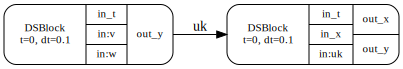

In [10]:
from pykal_core.utils.compute.sim_graph import SimGraph

G = SimGraph("MetaF")
with G.patch_simulation(compute.Simulation):
    xk1, yk1 = meta_f(xk, tk=0.0)

G.render()  # -> meta_f_graph.svg

In [ ]:
# next: write in all other stuff, spin up ros node 